In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax,blackjax
#jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax,bfield
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-22 15:48:57.823177: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


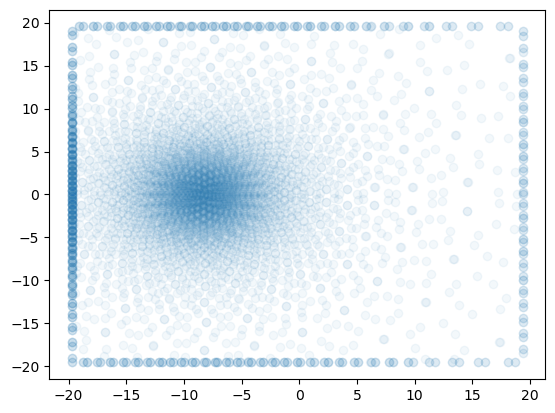

In [3]:
nside = 64
num_int_points = 512
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,500],poss[::10,1,500],alpha=0.05)

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))

C_field = C_page_vmap(poss[:,0,:].reshape(-1),poss[:,1,:].reshape(-1),poss[:,2,:].reshape(-1)).reshape((-1,num_int_points))*6.5e1/C_earth

In [5]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [6]:
dtype = np.float64
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
TE_field = tereg
interp_TE_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))
TE_field_interp = interp_TE_3d(poss)


In [7]:
nx,ny,nz = 128,128,32

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

interp_Bfield_3d = jax.vmap(lambda pos,bfield: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,bfield,method='linear',extrap=True),in_axes=(0,None))
B_field = jnp.ones((nx,ny,nz,3))*1e-6
interp_Bfield_3d(poss,B_field).shape

(49152, 512, 3)

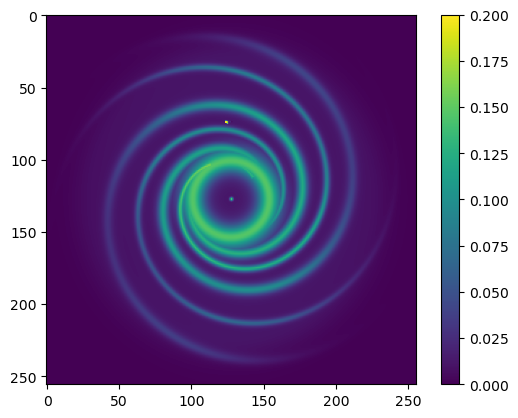

In [8]:
plt.imshow(TE_field[:,:,32],vmax=0.2)
plt.colorbar()

In [9]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}



In [10]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

## read observation and add noise

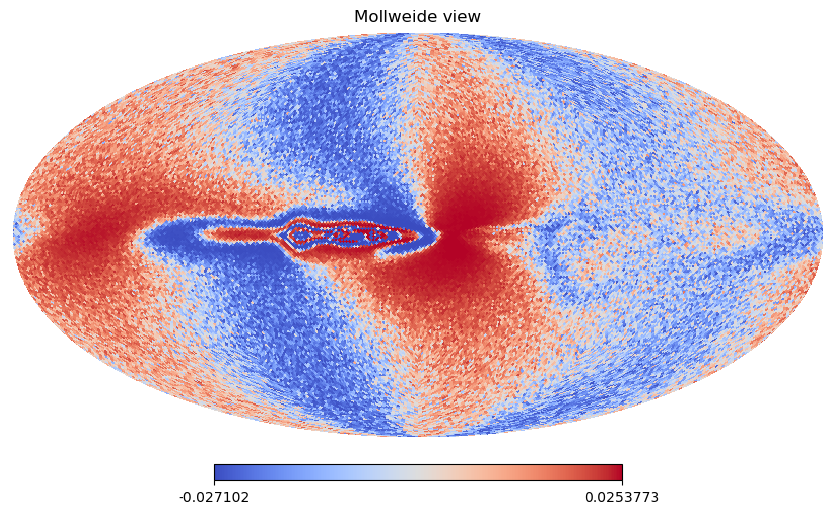

In [11]:
obs_maps = np.load('Sim_lsa.npy')
np.random.seed(42)
obs_Q = obs_maps[0,0] + np.random.randn(obs_maps[0,0].shape[0])*0.001
obs_U = obs_maps[1,0] + np.random.randn(obs_maps[0,0].shape[0])*0.001


hp.mollview(obs_Q,norm='hist',cmap='coolwarm')

In [12]:
@jax.jit
def grid_model(B_field,freq):

    B_field = interp_Bfield_3d(poss,B_field)
    B_los = -1*((nhats[:,jnp.newaxis,:]*B_field)).sum(axis=-1)
    phis = freq_irrelavent_const*TE_field_interp*B_los
    sinb = nhats[...,2]
    cosb = jnp.sqrt(1-sinb**2)
    cosl = nhats[...,0]/cosb
    sinl = nhats[...,1]/cosb

    Bz = B_field[...,2]
    By = B_field[...,1]
    Bx = B_field[...,0]
    tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
    chi0 = jnp.arctan(tanchi0)
    phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]

    fd = phi_int*const.c**2/(freq**2*1e18)
    fd_q = jnp.cos(2*fd+2*chi0)
    fd_u = jnp.sin(2*fd+2*chi0)


    B_field_square = (B_field**2).sum(axis=-1)

    B_trans = (B_field_square-B_los**2)**0.5

    emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
    Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
    Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls
    
    return Sync_Q_int,Sync_U_int

grid_model_vmap = jax.vmap(grid_model,in_axes=(None,0))
freqs = jnp.linspace(2.4,4.4,2)
freq = 2.4

def logdensity_fn(B_field):
    
    Sync_Q,Sync_U = grid_model(B_field,freq)

    return -1*jnp.sum(((Sync_Q-obs_Q)/0.001/2)**2) - jnp.sum(((Sync_U-obs_U)/0.001/2)**2)

#B_generator = bfield.B_lsa(coords)
#B_field = B_generator.B_field(lsa_params).reshape((nx,ny,nz,3))
B_field = (np.random.randn(nx,ny,nz,3)*1e-7)*jnp.array([1.,1.,0.1])
Sync_Q_int,Sync_U_int = grid_model_vmap(B_field,freqs)

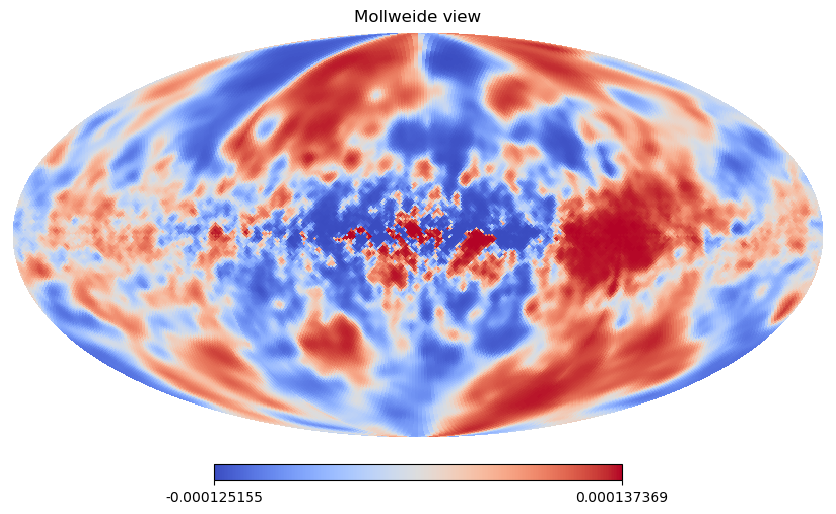

In [13]:
hp.mollview(Sync_U_int[0],norm='hist',cmap='coolwarm')

In [14]:
logp_grad = jax.value_and_grad(lambda x:-1*logdensity_fn(x))

In [18]:
import optax
from tqdm import tqdm

B_field = (np.random.randn(*(nx,ny,nz,3))*1e-7)*jnp.array([1.,1.,0.1])
#B_generator = bfield.B_lsa(coords)
#B_field = B_generator.B_field(lsa_params).reshape((nx,ny,nz,3))
B_opt = B_field
#solver = optax.yogi(1e-8)
solver = optax.yogi(learning_rate=1e-7)
#solver = optax.novograd(1e-6,)

opt_state = solver.init(B_opt)

loss = []

ones_field = np.ones((nx,ny,nz))

mask = ((coords[0]**2+coords[1]**2)>400)|((coords[0]**2+coords[1]**2)<9)

ones_field[mask] = 1e-10

mask = jnp.array(ones_field)[:,:,:,jnp.newaxis]
#mask = C_field/C_field.max()
B_opt = B_opt*mask

progress_bar = tqdm(range(200))
for i in progress_bar:
    value,grad = logp_grad(B_opt)
    if jnp.isnan(value):
        break
    #grad.at[jnp.abs(grad)>1e-6].set(1e-6)
    #grad = jnp.nan_to_num(grad, nan=1e-6)
    loss.append(value)
    updates, opt_state = solver.update(grad, opt_state, B_opt)
    B_opt = optax.apply_updates(B_opt, updates)
    B_opt = B_opt*mask
    #B_opt = jnp.where(B_opt > 1e-5, 1e-5, B_opt)
    info = { 'loss': loss[-1]}
    
    # Update the postfix with the current info
    progress_bar.set_postfix(info)

100%|██████████| 200/200 [01:24<00:00,  2.37it/s, loss=9493.156604842232] 


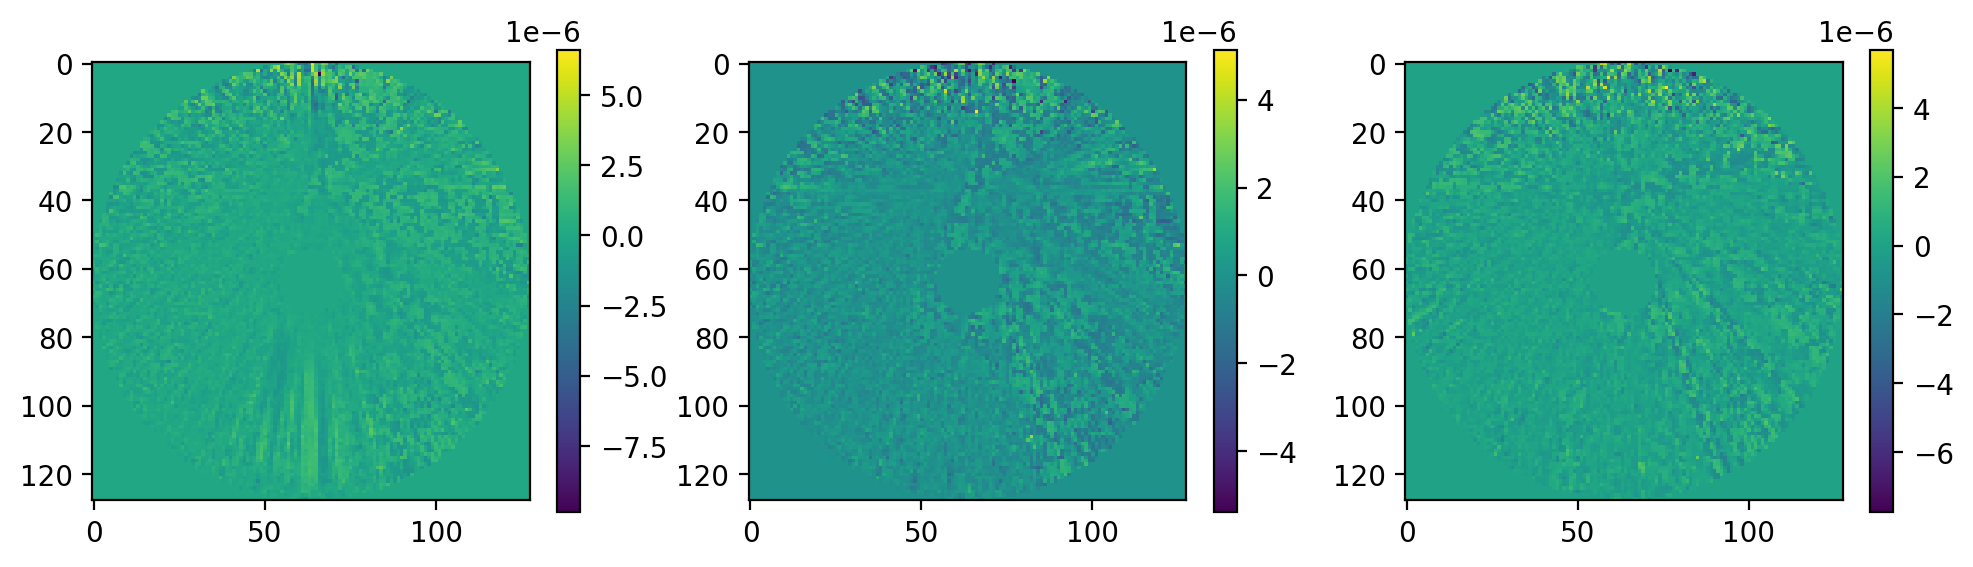

In [19]:
plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_opt[:,:,16,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(B_opt[:,:,16,1])
plt.colorbar()

plt.subplot(133)
plt.imshow(B_opt[:,:,16,2])
plt.colorbar()

In [58]:
Sync_Q_int,Sync_U_int = grid_model(B_opt,freq)

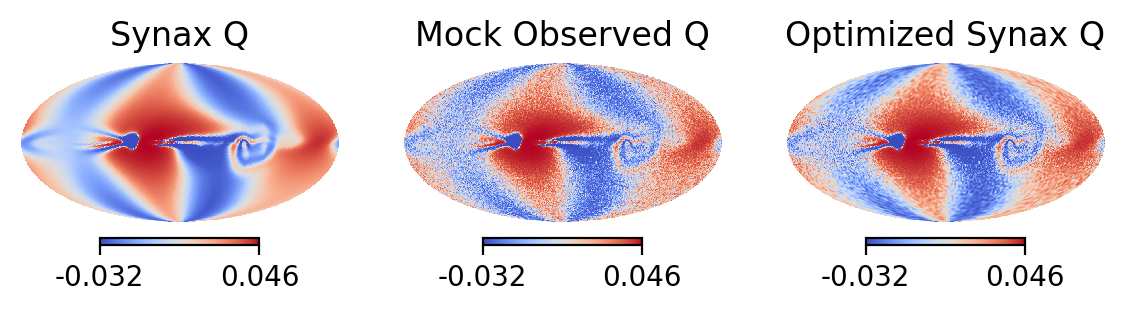

In [59]:
plt.figure(dpi=200,figsize=(7,2),)
np.random.seed(42)
plt.subplot(131)
hp.mollview(obs_maps[0,0],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax Q')

plt.subplot(132)
hp.mollview(obs_Q,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Mock Observed Q')

plt.subplot(133)
hp.mollview(Sync_Q_int,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Optimized Synax Q')

plt.savefig("lsa_opt.pdf",bbox_inches='tight',dpi=200)

Text(0.5, 1.0, 'Residuals')

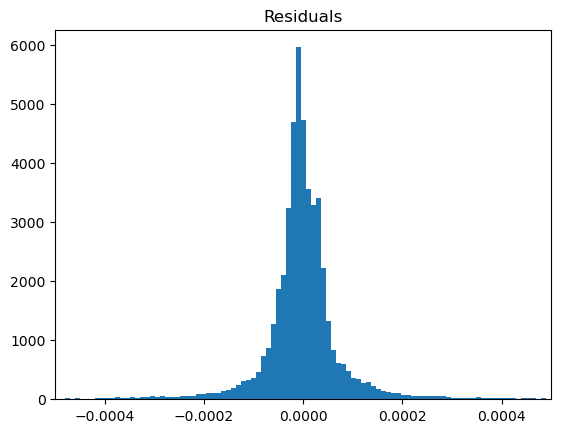

In [168]:
plt.hist(Sync_U_int[idx]-obs_U[idx],bins=np.linspace(-0.0005,0.0005,100))
plt.xlim((-0.0005,0.0005))
plt.title('Residuals')

In [16]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

B_generator = bfield.B_lsa(coords)
B_true = B_generator.B_field(lsa_params).reshape((nx,ny,nz,3))

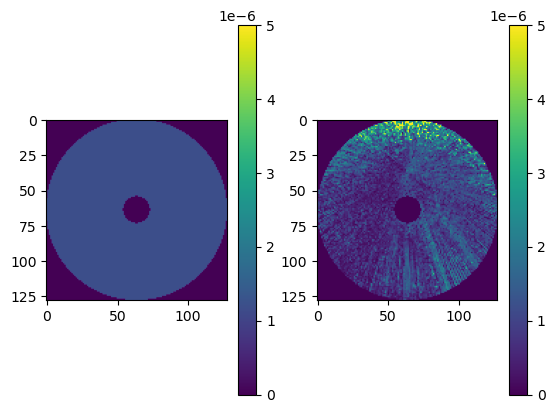

In [22]:
plt.subplot(121)
plt.imshow(((B_true**2).sum(axis=-1)**(1/2))[:,:,16],vmax=5e-6,vmin = 0)
plt.colorbar()

plt.subplot(122)
plt.imshow(((B_opt**2).sum(axis=-1)**(1/2))[:,:,16],vmax=5e-6,vmin = 0)
plt.colorbar()

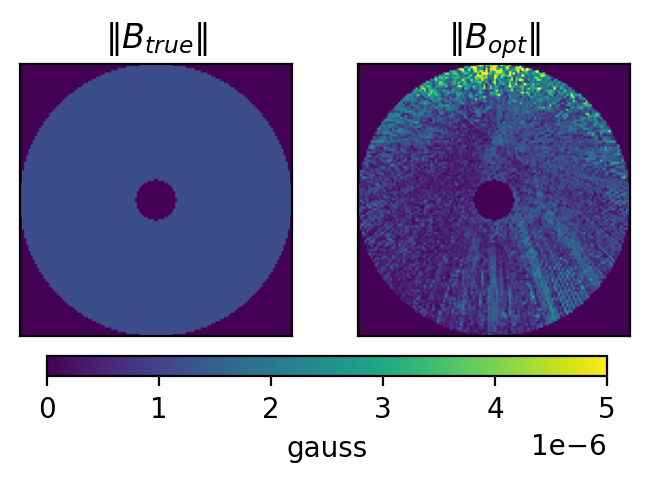

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2),dpi=200)

# Plot the first subplot
im1 = axs[0].imshow(((B_true**2).sum(axis=-1)**(1/2))[:,:,16], vmax=5e-6, vmin=0)
axs[0].set_title(r'$\Vert B_{true} \Vert$')

axs[0].set_xticks([])  # Turn off x ticks
axs[0].set_yticks([])

# Plot the second subplot
im2 = axs[1].imshow(((B_opt**2).sum(axis=-1)**(1/2))[:,:,16], vmax=5e-6, vmin=0)
axs[1].set_title(r'$\Vert B_{opt} \Vert$')

axs[1].set_xticks([])  # Turn off x ticks
axs[1].set_yticks([])

# Add the colorbar
fig.subplots_adjust(bottom=0.2)  # Make space for the colorbar
cbar_ax = fig.add_axes([0.165, 0.1, 0.7, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('gauss')

plt.savefig('opt_B.pdf',dpi=500)